# Data Preparation

## load& read

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from imblearn.over_sampling import SMOTE

In [2]:
df=pd.read_csv("cumulative_2025.09.28_14.55.38.csv" ,skiprows=86)


In [3]:
df.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,...,-0.021,-0.038,0.00070,0.00060,-0.025,-0.034,0.042,0.002,-0.027,0.027
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6390 entries, 0 to 6389
Data columns (total 83 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              6390 non-null   int64  
 1   kepid              6390 non-null   int64  
 2   kepoi_name         6390 non-null   object 
 3   kepler_name        2693 non-null   object 
 4   koi_disposition    6390 non-null   object 
 5   koi_vet_stat       6390 non-null   object 
 6   koi_vet_date       6390 non-null   object 
 7   koi_pdisposition   6390 non-null   object 
 8   koi_score          5815 non-null   float64
 9   koi_fpflag_nt      6390 non-null   int64  
 10  koi_fpflag_ss      6390 non-null   int64  
 11  koi_fpflag_co      6390 non-null   int64  
 12  koi_fpflag_ec      6390 non-null   int64  
 13  koi_disp_prov      6390 non-null   object 
 14  koi_comment        5873 non-null   object 
 15  koi_period         6390 non-null   float64
 16  koi_time0bk        6390 

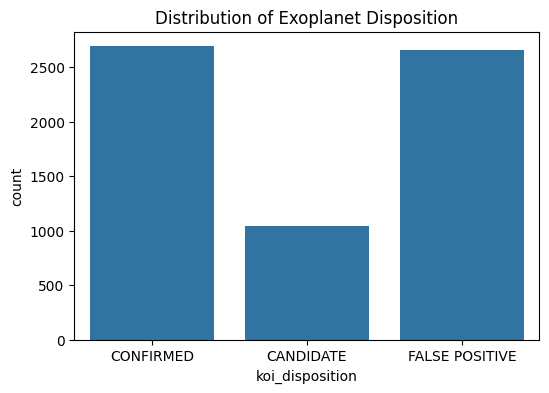

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x="koi_disposition", data=df)
plt.title("Distribution of Exoplanet Disposition")
plt.show()

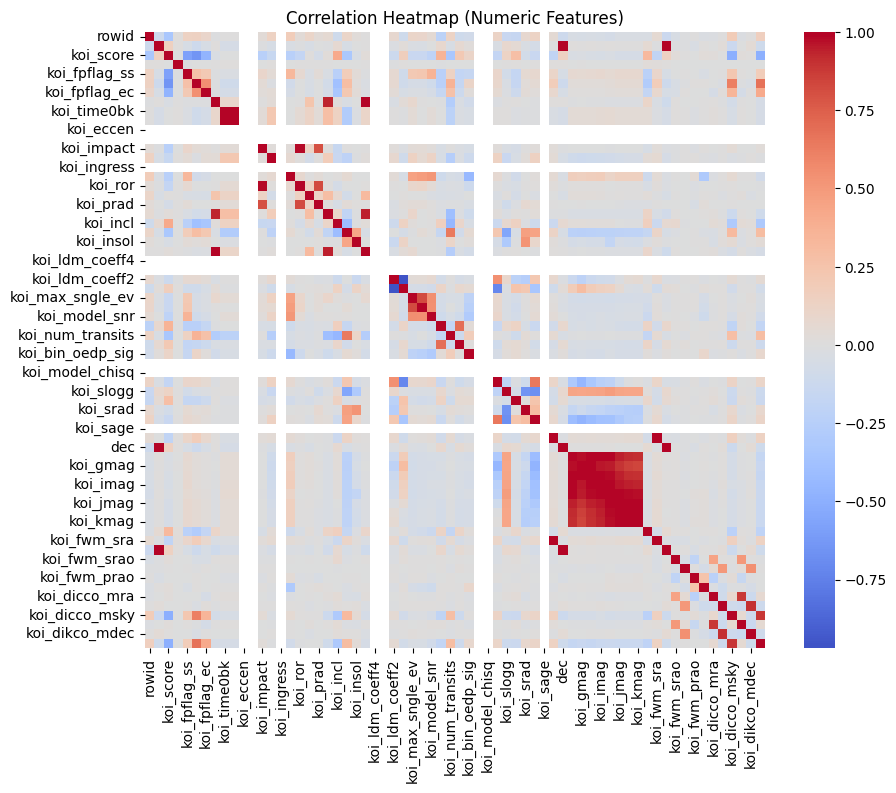

In [6]:
plt.figure(figsize=(10,8))
numeric_cols = df.select_dtypes(include=['float64','int64'])
corr = numeric_cols.corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

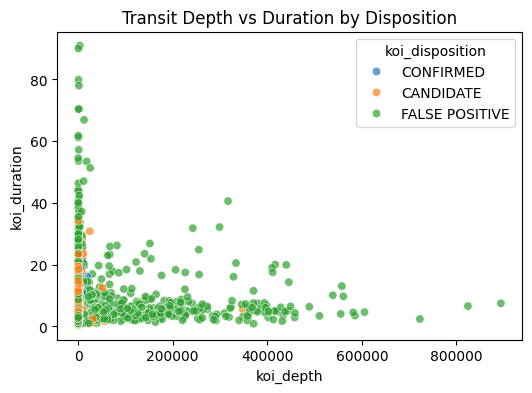

In [7]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="koi_depth", y="koi_duration", hue="koi_disposition", data=df, alpha=0.7)
plt.title("Transit Depth vs Duration by Disposition")
plt.show()

In [8]:
df.isnull().sum()

,0
rowid,0
kepid,0
kepoi_name,0
kepler_name,3697
koi_disposition,0
...,...
koi_dicco_mdec,477
koi_dicco_msky,477
koi_dikco_mra,456
koi_dikco_mdec,456


In [9]:
summary = pd.DataFrame({
    'dtype': df.dtypes,
    'num_nulls': df.isnull().sum(),
    'perc_nulls': (df.isnull().sum() / len(df)) * 100,
    'unique_values': df.nunique()
})

print(summary)


                   dtype  num_nulls  perc_nulls  unique_values
rowid              int64          0    0.000000           6390
kepid              int64          0    0.000000           5339
kepoi_name        object          0    0.000000           6390
kepler_name       object       3697   57.856025           2693
koi_disposition   object          0    0.000000              3
...                  ...        ...         ...            ...
koi_dicco_mdec   float64        477    7.464789           1638
koi_dicco_msky   float64        477    7.464789           1436
koi_dikco_mra    float64        456    7.136150           1670
koi_dikco_mdec   float64        456    7.136150           1745
koi_dikco_msky   float64        456    7.136150           1538

[83 rows x 4 columns]


## Handling

In [10]:
drop_cols = ["rowid","kepid","kepoi_name","kepler_name","koi_vet_date",
             "koi_comment","koi_disp_prov","koi_tce_delivname",
             "koi_datalink_dvr","koi_datalink_dvs","koi_sparprov",
             "koi_longp","koi_ingress","koi_model_dof","koi_model_chisq","koi_sage"]
df = df.drop(columns=drop_cols, errors='ignore')

for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col] = df[col].fillna(df[col].median())

for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna("Unknown")


In [11]:
df.isnull().sum()

,0
koi_disposition,0
koi_vet_stat,0
koi_pdisposition,0
koi_score,0
koi_fpflag_nt,0
...,...
koi_dicco_mdec,0
koi_dicco_msky,0
koi_dikco_mra,0
koi_dikco_mdec,0


In [12]:
y = df["koi_disposition"]
X = df.drop(columns=["koi_disposition"])

In [13]:
encoders = {}
for col in X.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    encoders[col] = le


## features Engineering

In [14]:
df["depth_duration_ratio"] = df["koi_depth"] / (df["koi_duration"] + 1e-6)
df["radius_temp_ratio"] = df["koi_prad"] / (df["koi_teq"] + 1e-6)
df["orbital_log"] = np.log1p(df["koi_period"])
df["stellar_flux_ratio"] = df["koi_steff"] / (df["koi_period"] + 1e-6)


# Model

## first Model for all data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(pd.Series(y_train).value_counts(normalize=True))

koi_disposition
CONFIRMED         0.421318
FALSE POSITIVE    0.415580
CANDIDATE         0.163102
Name: proportion, dtype: float64


In [17]:
lgbm_full = lgb.LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=8,
    num_leaves=40,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42,
    verbose=-1
)

lgbm_full.fit(X_train_scaled, y_train)


y_pred_full = lgbm_full.predict(X_test_scaled)
print(" [FULL MODEL] Accuracy:", accuracy_score(y_test, y_pred_full))
print("\n [FULL MODEL] Classification Report:\n", classification_report(y_test, y_pred_full))
print("\n [FULL MODEL] Confusion Matrix:\n", confusion_matrix(y_test, y_pred_full))



 [FULL MODEL] Accuracy: 0.9374021909233177

 [FULL MODEL] Classification Report:
                 precision    recall  f1-score   support

     CANDIDATE       0.86      0.74      0.79       104
     CONFIRMED       0.90      0.95      0.93       269
FALSE POSITIVE       1.00      1.00      1.00       266

      accuracy                           0.94       639
     macro avg       0.92      0.90      0.91       639
  weighted avg       0.94      0.94      0.94       639


 [FULL MODEL] Confusion Matrix:
 [[ 77  27   0]
 [ 13 256   0]
 [  0   0 266]]


## second Model for front

In [18]:
features = ["koi_period", "koi_prad", "koi_smass", "koi_teq", "koi_depth"]
df_small = pd.read_csv("cumulative_2025.09.28_14.55.38.csv", skiprows=86)
target = "koi_disposition"
df_small = df_small[features + [target]].dropna()

X_small = df_small[features]
y_small = df_small[target]

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_small, y_small, test_size=0.2, random_state=42, stratify=y_small
)

scaler_small = StandardScaler()
X_train_s_scaled = scaler_small.fit_transform(X_train_s)
X_test_s_scaled = scaler_small.transform(X_test_s)

In [19]:
lgbm_front = lgb.LGBMClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=30,
    class_weight="balanced",
    random_state=42
)

lgbm_front.fit(X_train_s_scaled, y_train_s)
y_pred_front = lgbm_front.predict(X_test_s_scaled)
print("\n[FRONT MODEL] Accuracy:", accuracy_score(y_test_s, y_pred_front))
print("\n [FRONT MODEL] Classification Report:\n", classification_report(y_test_s, y_pred_front))
print("\n [FRONT MODEL] Confusion Matrix:\n", confusion_matrix(y_test_s, y_pred_front))



[FRONT MODEL] Accuracy: 0.6746602717825739

 [FRONT MODEL] Classification Report:
                 precision    recall  f1-score   support

     CANDIDATE       0.35      0.36      0.35       204
     CONFIRMED       0.71      0.75      0.73       538
FALSE POSITIVE       0.78      0.72      0.75       509

      accuracy                           0.67      1251
     macro avg       0.61      0.61      0.61      1251
  weighted avg       0.68      0.67      0.68      1251


 [FRONT MODEL] Confusion Matrix:
 [[ 73  75  56]
 [ 86 405  47]
 [ 50  93 366]]


# Model Saving

In [20]:
joblib.dump(lgbm_front, "AEXIS_front.pkl")
joblib.dump(scaler_small, "scaler_front.pkl")
joblib.dump(features, "feature_names_front.pkl")

['feature_names_front.pkl']

In [21]:
import joblib
import pandas as pd

def predict_exoplanet_front(orbital_period, planet_radius, stellar_mass, equilibrium_temp, transit_depth):
    model = joblib.load("AEXIS_front.pkl")
    scaler = joblib.load("scaler_front.pkl")
    feature_names = joblib.load("feature_names_front.pkl")

    user_input = {
        "koi_period": orbital_period,
        "koi_prad": planet_radius,
        "koi_smass": stellar_mass,
        "koi_teq": equilibrium_temp,
        "koi_depth": transit_depth
    }

    sample_df = pd.DataFrame([[user_input[f] for f in feature_names]], columns=feature_names)


    sample_scaled = scaler.transform(sample_df)


    pred = model.predict(sample_scaled)[0]
    probs = model.predict_proba(sample_scaled)[0]
    classes = model.classes_


    print(f"\predict {pred}\n")
    print("Probability")
    for i, cls in enumerate(classes):
        print(f" - {cls}: {round(float(probs[i]), 3)}")


In [22]:
#Many test cases
test_cases = [
    (3.5, 11.0, 1.1, 1500, 20000),   #
    (50.0, 1.2, 0.9, 500, 200),      #
    (1.5, 15.0, 1.3, 2500, 50000),   #
    (365.0, 1.0, 1.0, 300, 1000)     #
]

for i, case in enumerate(test_cases, start=1):
    print(f"\n================= test{i} =================")
    predict_exoplanet_front(*case)



================= test1 =================
\predict CONFIRMED

Probability
 - CANDIDATE: 0.006
 - CONFIRMED: 0.965
 - FALSE POSITIVE: 0.029

================= test2 =================
\predict CANDIDATE

Probability
 - CANDIDATE: 0.947
 - CONFIRMED: 0.027
 - FALSE POSITIVE: 0.026

================= test3 =================
\predict FALSE POSITIVE

Probability
 - CANDIDATE: 0.002
 - CONFIRMED: 0.016
 - FALSE POSITIVE: 0.982

================= test4 =================
\predict FALSE POSITIVE

Probability
 - CANDIDATE: 0.009
 - CONFIRMED: 0.0
 - FALSE POSITIVE: 0.991


# Backend Integration

In [23]:
def predict_exoplanet_front(orbital_period, planet_radius, stellar_mass, equilibrium_temp, transit_depth):
    model = joblib.load("AEXIS_front.pkl")
    scaler = joblib.load("scaler_front.pkl")
    feature_names = joblib.load("feature_names_front.pkl")

    user_input = {
        "koi_period": orbital_period,
        "koi_prad": planet_radius,
        "koi_smass": stellar_mass,
        "koi_teq": equilibrium_temp,
        "koi_depth": transit_depth
    }

    sample_df = pd.DataFrame([[user_input[f] for f in feature_names]], columns=feature_names)
    sample_scaled = scaler.transform(sample_df)

    pred = model.predict(sample_scaled)[0]
    probs = model.predict_proba(sample_scaled)[0]
    result = {cls: round(float(probs[i]), 3) for i, cls in enumerate(model.classes_)}
    return {"prediction": pred, "probabilities": result}

